In [1]:
%matplotlib inline

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import interpolate
from functools import partial

from sgmrc.sgmcoint.space import johansen, normalise
from sgmrc.sgmcoint.common import is_nonstationary
from sgmrc.sgmcoint.regression import add_constant, coch_regression
from sgmrc.sgmcoint.simulation import dgp2
from sgmrc.sgmcoint.projection import project, rescale

from sgmarb.backtesting.data import clean_dataframe
from sgmarb.backtesting.cointegration import combine_dataframes, generate_signals

In [16]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (16, 8)

# Cointegration Experiments:

In [6]:
def load_df(path):
    df = pd.read_csv(path)
    df = df[df['delay'] > 0]
    df['timestamp'] = pd.to_datetime(df.timestamp, unit='ms')

    return clean_dataframe(df)

In [7]:
def splined(df, interval):
    df['elapsed'] = df.index.values - df.index.values[0]
    df['elapsed_seconds'] = df['elapsed'].astype(int) / 1000000000

    time_range = np.arange(0, df.elapsed_seconds.max(), interval)
    tgt_interpolated = interpolate.interp1d(df.elapsed_seconds, (df.bp1 + df.lp1) / 2., kind='zero')(time_range)

    return interpolate.UnivariateSpline(time_range, tgt_interpolated, k=3, s=1)(time_range)

In [20]:
def get_pair(eid):
    return combine_dataframes(
        load_df('/home/tspooner/.oddscache/odds_T-EENP%d-FT12-A.BF.csv.gz' % eid),
        load_df('/home/tspooner/.oddscache/odds_T-EENP%d-FT12-B.BF.csv.gz' % eid)
    )

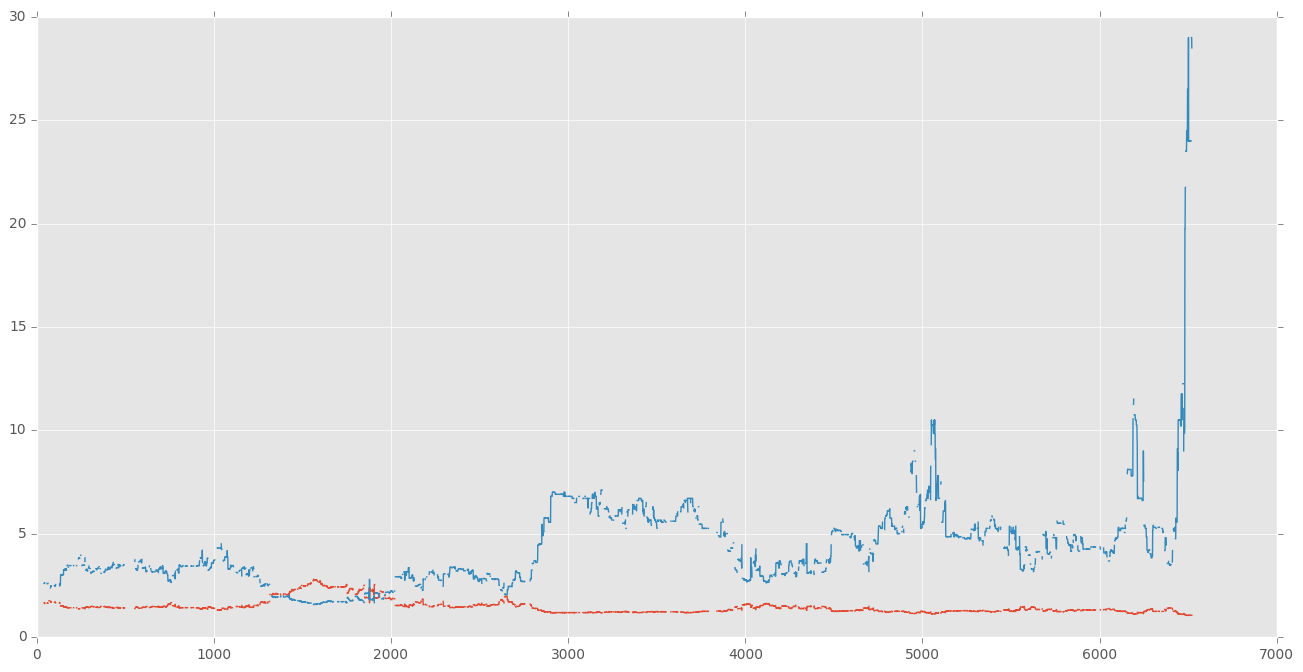

In [32]:
df = get_pair(2615669)
_ = plt.plot(df[['ref_1', 'ref_2']])

In [34]:
signals = generate_signals(df)

KeyboardInterrupt: 

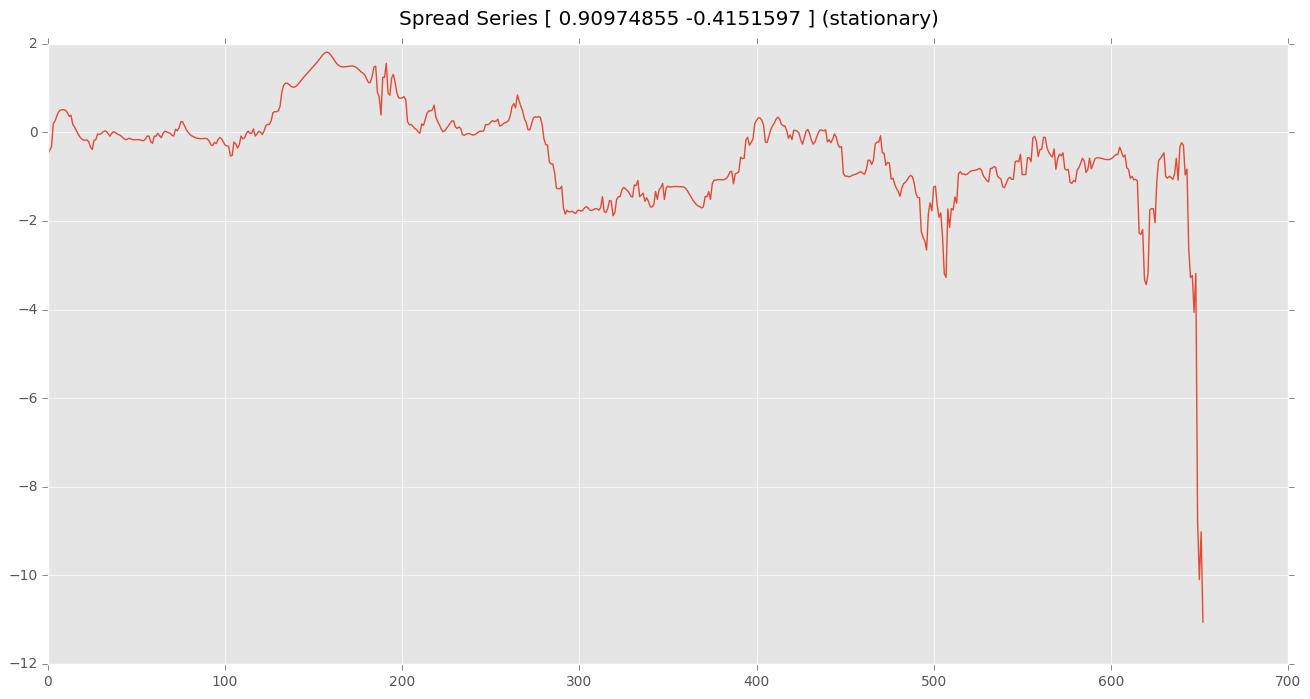

In [23]:
b = normalise(johansen(X, 1))
spread = project(X, b)

plt.plot(spread)
_ = plt.title('Spread Series %s (%sstationary)' % (b.ravel(), '' if is_nonstationary(spread.ravel()) else 'non-'), y=1.02)

## Lookback window:

In [34]:
def signal_co(spd, sample_rate=1):
    idx = np.arange(0, spd.shape[0], sample_rate)
    x = idx.astype(np.float) / (spd.shape[0]-1)

    spd = spd[idx]

    params, pvalues = coch_regression(add_constant(x), rescale(spd))
    if pvalues[1] < 0.05:
        if params[1] > 0.1:
            return 1
        elif params[1] < -0.1:
            return -1

    return 0

In [35]:
def signal_gp(spd, sample_rate=10):
    pass

In [36]:
def handle(X, slw, signal):
    for i in range(slw, X.shape[0]):
        # Get data window:
        x = X[(i-slw):i, :]

        # Project onto cointregation space:
        b = normalise(johansen(x, rank=1))
        spd = project(x, b).ravel()

        if not is_nonstationary(spd, crit='5%'):
            yield signal(spd)
        else:
            yield 0

    return

In [37]:
def zero_runs(a):
    iszero = np.concatenate(([0], np.equal(a, 0).view(np.int8), [0]))
    absdiff = np.abs(np.diff(iszero))
    return np.where(absdiff == 1)[0].reshape(-1, 2)

def signal_plot(X, signals):
    f = plt.figure()

    plt.plot(X[:, 0], drawstyle='steps-post', label='A')
    plt.plot(X[:, 1], drawstyle='steps-post', label='B')

    groups = zero_runs(signals <= 0)
    plt.axvspan(groups[0, 0], groups[0, 1], color='red', alpha=0.1, label='Long')
    for tr in groups[1:]:
        plt.axvspan(tr[0], tr[1], color='red', alpha=0.1)

    groups = zero_runs(signals >= 0)
    plt.axvspan(groups[0, 0], groups[0, 1], color='blue', alpha=0.1, label='Short')
    for tr in groups[1:]:
        plt.axvspan(tr[0], tr[1], color='blue', alpha=0.1)

    plt.legend()

    return f

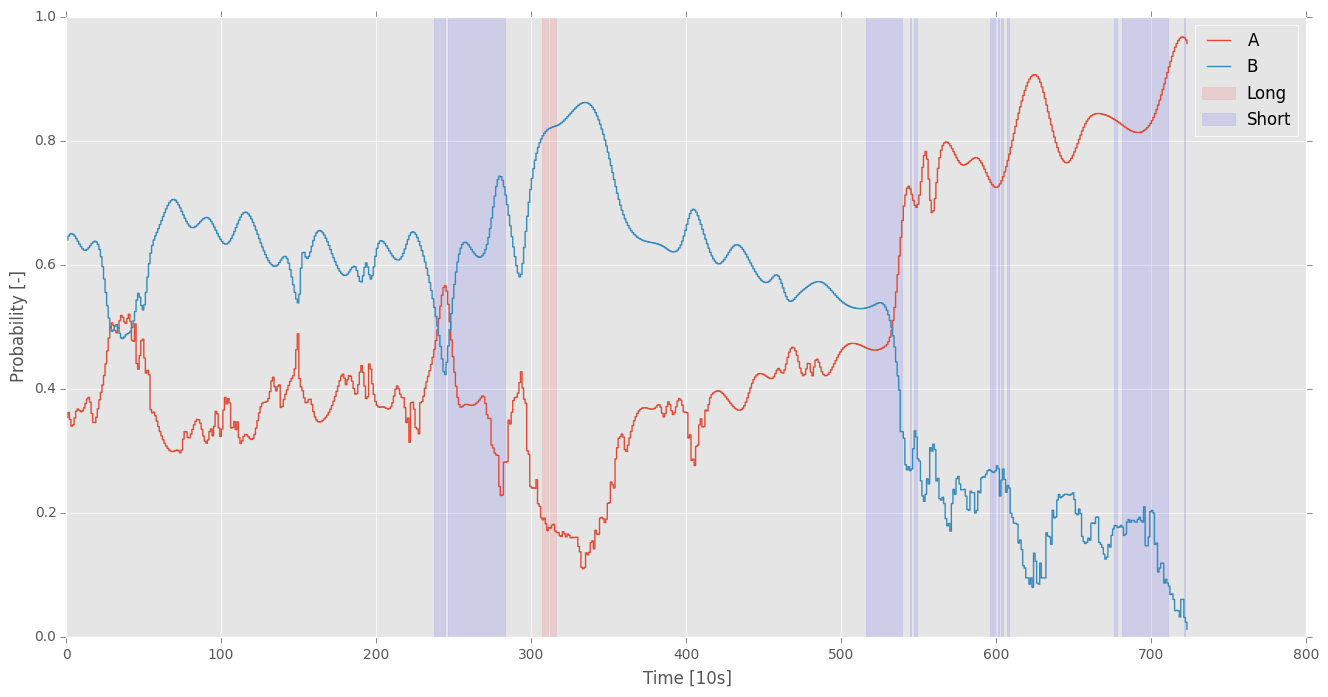

In [38]:
SLW = 200

X = get_pair(2608757, spline_interval=10)
signals = np.append(np.zeros(SLW), np.array(list(handle(X, SLW, partial(signal_co, sample_rate=1)))))

f1 = signal_plot(1/X, signals)
plt.xlabel('Time [10s]')
plt.ylabel('Probability [-]')